# Distribution grid design for minigrids

Prepared for: [Julián Cantor](https://www.linkedin.com/in/juliancantor/) 

The script is designed to create distribution networks for minigrids, providing insights into the quantities of trunk lines, branches, service lines, and poles. Compared to common approaches that estimate total length using the Minimum Spanning Tree (MST), this script offers more granularity. It allows building the grid along existing roads (when available) or utilizes Voronoi polygons to create artificial roads when no road data exists. The algorithm was tested and compared with the MST for five randomly chosen locations in Zambia. Table No 1 summarizes the main differences.

| No. Households | Total length mst (km) | Time MST (minutes) |   | Total length design (km) | No. Poles | Time design (minutes) |
|:--------------:|:---------------------:|:------------------:|---|:------------------------:|:---------:|:---------------------:|
|      2122      |          36.8         |        1.69        |   |           82.42          |    494    |          0.27         |
|       751      |          18.2         |        0.20        |   |           38.29          |    332    |          0.14         |
|       755      |          12.5         |        0.22        |   |           28.25          |    183    |          0.13         |
|       626      |          8.1          |        0.17        |   |           22.51          |    102    |          0.06         |
|       517      |          7.1          |        0.11        |   |           21.16          |     84    |          0.06         |

The following figure shows the main difference between the present work and the classic MST. While this script allows for obtaining grids, the MST simply connects the different households. This results in an underestimation of the final length, which also leads to a non-optimal estimation of distribution costs.

**Figure 1:** Distribution network design with this algorithm
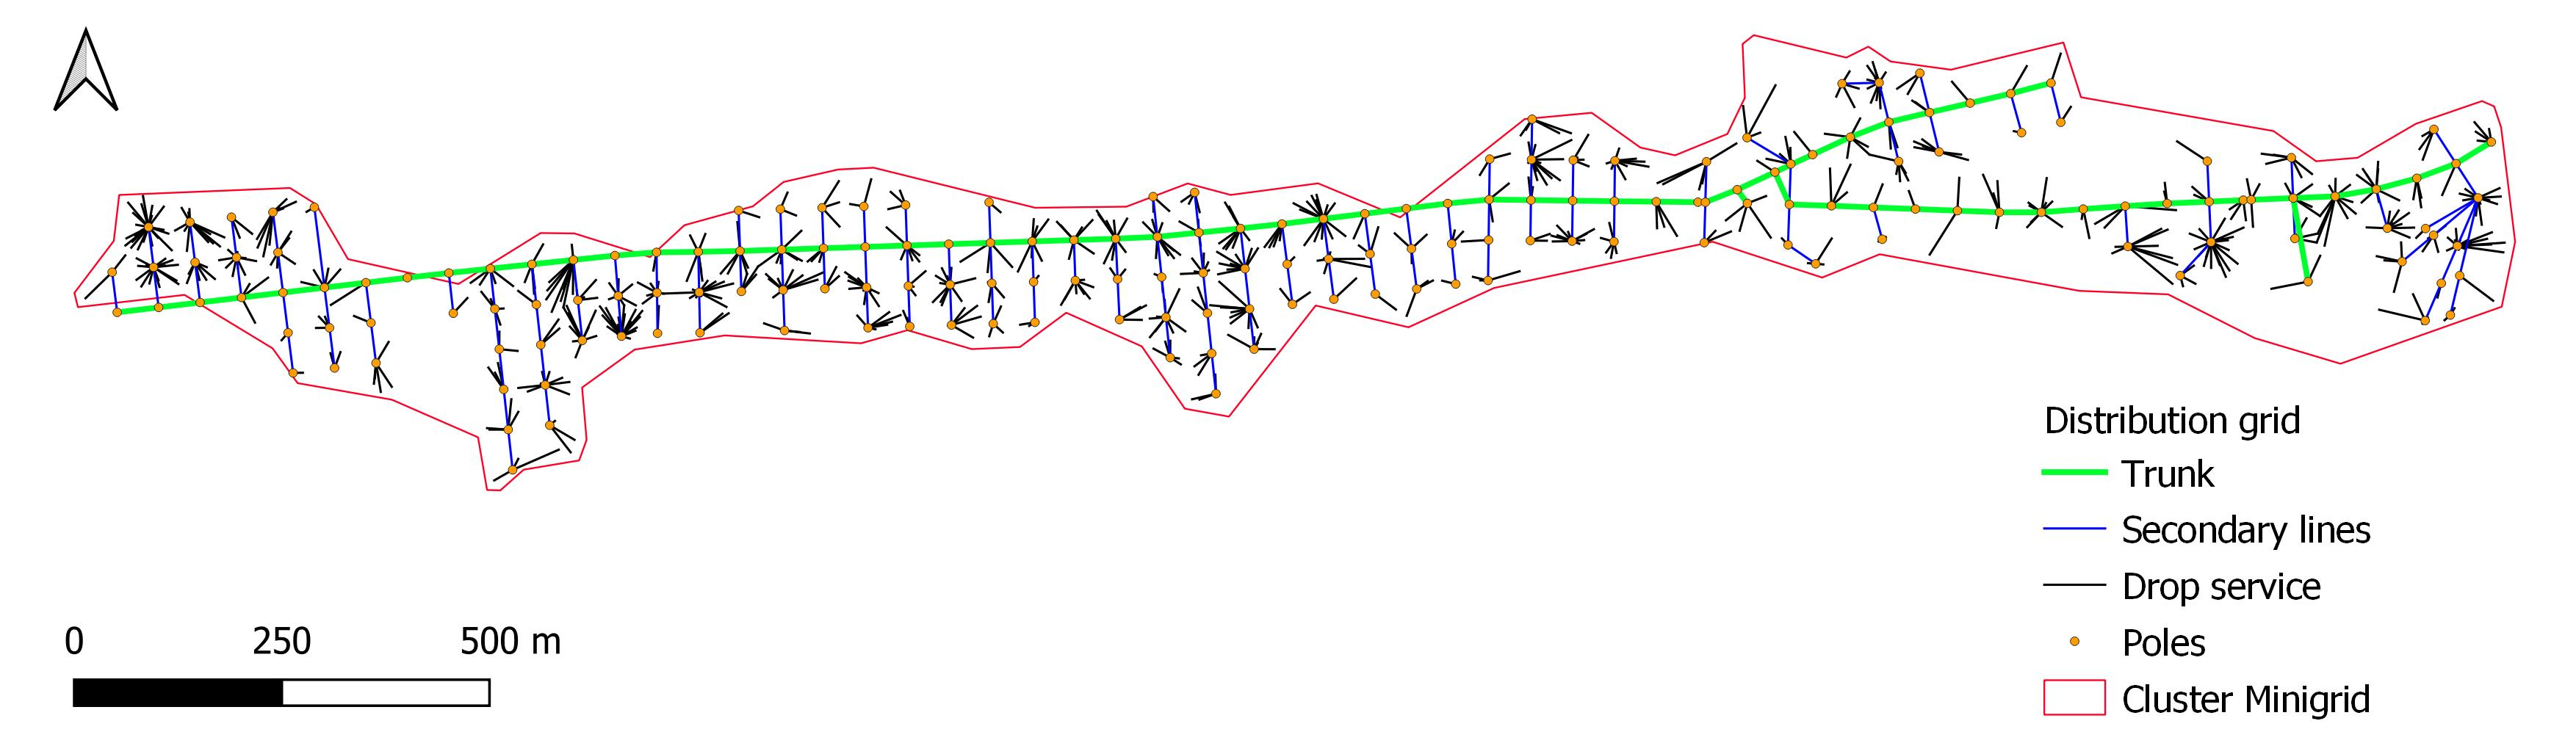

**Figure 2:** Distribution network design with MST
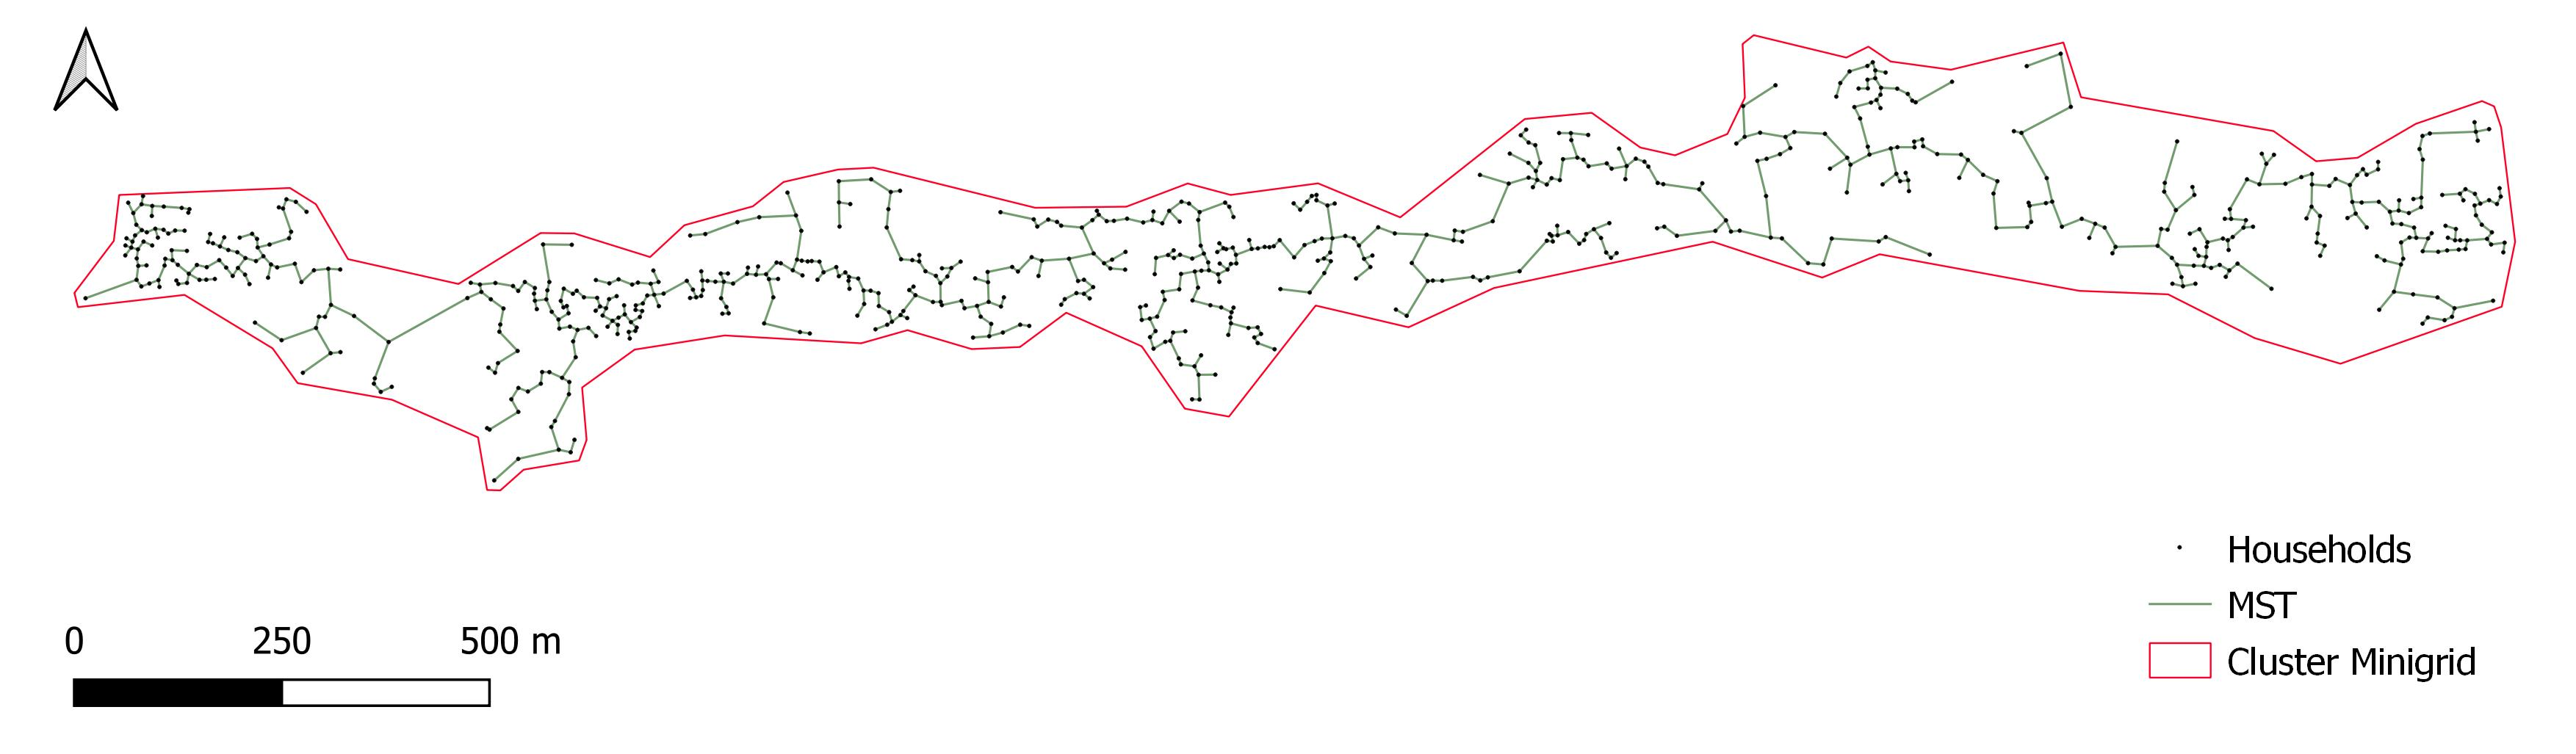

This notebook is divided into three parts. The first part introduces the necessary packages required to run the script. The second part defines functions used to obtain the distribution grids. Finally, the third part provides an example application in Zambia to illustrate the expected output.

## 1. Importing packages

In [1]:
import geopandas as gpd
import pandas as pd
import pyproj
import numpy as np
import fiona
import time
import warnings
import os

from math import sqrt
import math
from math import degrees

from functools import reduce
from shapely.geometry import Point, Polygon, MultiPoint, LineString, MultiLineString, MultiPolygon

import folium
from folium.features import GeoJsonTooltip
import branca.colormap as cm

from IPython.display import display, Markdown, HTML, FileLink, FileLinks
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import networkx as nx

from scipy.spatial import distance_matrix
from shapely.ops import split, linemerge, nearest_points
from scipy.spatial import Voronoi

## 2. Functions

### 2.1. Functions to create candidate poles

The following funtions allow to create poles along the roads, and poles perpendicular to those already created. To avoid overlapping of poles there are some extra necesary functions. 

In [2]:
def clip_geometries(geometry_from_data_frame, input_gdf1, input_gdf2):


    # Inputs:
    #   geometry_from_data_frame (polygon): The study area polygon where minigrids will be created.
    #   input_gdf1: buildings_point_layer (point layer): This layer should contain building locations. 
    #       The script is designed to first process buildings and create a convex hull around them. 
    #       This creates an artificial geometry larger than the study area to avoid unconnected roads.
    #   input_gdf2 roads_layer (line layer): The layer containing the road network data.
    
    # Outputs:
    #   clipped_gdf1: clipped_buildings (point layer): The buildings clipped to the study area polygon.
    #   clipped_gdf2: clipped_roads (line layer): The road segments that fall within the study area polygon.

    
    clipped_gdf1 = gpd.clip(input_gdf1, geometry_from_data_frame)
    convex_hull_polygon = MultiPoint(list(clipped_gdf1['geometry'])).convex_hull
    convex_hull_gdf = gpd.GeoDataFrame(geometry=[convex_hull_polygon], crs=local_crs)
    clipped_gdf2 = gpd.clip(input_gdf2, convex_hull_gdf)
    return clipped_gdf1, clipped_gdf2

In [3]:
def clip(geometry_from_data_frame, input_gdf1):
    #Simple clipping function
    clipped_gdf1 = gpd.clip(input_gdf1, geometry_from_data_frame)
    return clipped_gdf1

In [4]:
def poles_along_road(line, distance, index, index_road):
  """
  This function takes a road linestring geometry, a desired pole placement distance,
  and two indices for identification purposes, and returns a GeoDataFrame containing 
  the locations for placing poles along the road.

  Args:
      line (GeoPandas LineString): The linestring geometry representing the road.
      distance (float): The desired distance between poles in meters.
      index (int): An index for identifying the specific road segment.
      index_road (int): An index for further road network identification (optional).

  Returns:
      GeoDataFrame: A GeoDataFrame containing points with 'geometry' and 
                    identification columns ('ID_Road' and 'ID_No').
  """

  # Get the total length of the road linestring
  total_length = line.length

  # Calculate the number of poles to be placed based on distance
  num_points = int(total_length / distance)

  # Initialize an empty list to store pole locations
  points = []

  # Loop through the desired number of poles (including endpoints)
  for i in range(num_points + 1):
    # Calculate the proportional distance along the line for each pole
    position = float(i) / num_points

    # Interpolate the linestring to get the point geometry at the position
    point = line.interpolate(position, normalized=True)

    # Create a dictionary with the point geometry and identification information
    pole_data = {'geometry': point, 'ID_Road': index, 'ID_No': i}

    # Append the pole data dictionary to the list
    points.append(pole_data)

  # Create a GeoDataFrame from the list of pole data with specified CRS
  return gpd.GeoDataFrame(points, crs=local_crs)


In [5]:
def perpendicular_lines(point1, point2, length):
  """
  This function takes two Point objects and a desired length, and returns a LineString geometry
  representing a line perpendicular to the line connecting the two points, with the specified length.

  Args:
      point1 (GeoPandas Point): The first point defining the line.
      point2 (GeoPandas Point): The second point defining the line.
      length (float): The desired length of the perpendicular line in meters.

  Returns:
      GeoPandas LineString: The LineString geometry representing the perpendicular line.
  """

  # Extract x and y coordinates from the Point objects
  x1, y1 = point1.x, point1.y
  x2, y2 = point2.x, point2.y

  # Calculate the slope of the line connecting the two points
  slope = (y2 - y1) / (x2 - x1) if x2 - x1 != 0 else float('inf')  # Handle coincident points

  # Calculate the negative reciprocal of the slope for the perpendicular line
  slope_perpendicular = -1 / slope

  # Handle vertical lines (infinite slope) by setting a very large perpendicular slope
  if slope == 0:
    slope_perpendicular = float('inf')

  # Calculate the direction vector for the perpendicular line with a magnitude of length/sqrt(2)
  # This ensures equal contribution from x and y components regardless of slope
  dx = length / (2 * (1 + slope_perpendicular**2))**0.5
  dy = slope_perpendicular * dx

  # Calculate the endpoints of the perpendicular line by translating point1 along dx and dy
  x3 = x1 + dx
  y3 = y1 + dy
  x4 = x1 - dx
  y4 = y1 - dy

  # Create Point objects for the endpoints
  endpoint1 = Point(x3, y3)
  endpoint2 = Point(x4, y4)

  # Construct and return the LineString geometry representing the perpendicular line
  return LineString([endpoint1, endpoint2])

In [6]:
def calculate_points_on_line(line, midpoint, d, n, starting_index, id_road):
  """
  This function takes a line segment, a midpoint, desired distance, number of points,
  starting index, and road ID, and returns a GeoDataFrame containing points positioned 
  at the specified distance from the midpoint on either side of the line.

  Args:
      line (GeoPandas LineString): The line segment geometry.
      midpoint (GeoPandas Point): The midpoint of the line segment.
      d (float): The desired distance between points and the line in meters.
      n (int): The number of points to place on each side of the midpoint.
      starting_index (int): The starting index for pole identification.
      id_road (int): The road segment identifier.

  Returns:
      GeoDataFrame: A GeoDataFrame containing 'geometry', 'ID_Road', 
                    'ID_branch', 'geometry_to_pole_x', and 'geometry_to_pole_y' columns.
  """

  # Check for vertical line (undefined slope)
  if line.coords[1][0] - line.coords[0][0] == 0:
    return None  # Indicate error or handle vertical lines differently

  # Calculate the slope of the line segment
  slope = (line.coords[1][1] - line.coords[0][1]) / (line.coords[1][0] - line.coords[0][0])

  # Initialize empty lists to store points and corresponding indices
  points = []
  index_for_pole = []

  for i in range(1, n + 1):
    # Calculate the offset distances in x and y directions based on slope
    dx = d / np.sqrt(1 + slope**2)
    dy = slope * dx

    # Calculate points on both sides of the midpoint using offsets
    point1 = Point(midpoint.x + i * dx, midpoint.y + i * dy)
    point2 = Point(midpoint.x - i * dx, midpoint.y - i * dy)

    # Append points to the list
    points.extend([point1, point2])

    # Generate and append corresponding indices for each point (2 per iteration)
    index_for_pole.append(starting_index)
    index_for_pole.append(starting_index + 1)
    starting_index += 2

  # Create a GeoDataFrame with points and specified CRS
  poles = gpd.GeoDataFrame(geometry=points, crs=local_crs)

  # Add additional columns with road ID, branch ID, and reference point coordinates
  poles['ID_Road'] = id_road
  poles['ID_branch'] = index_for_pole
  poles['geometry_to_pole_x'] = midpoint.x
  poles['geometry_to_pole_y'] = midpoint.y

  return poles


In [7]:
def identifying_truck(roads_data):
        """
      This function takes a GeoDataFrame containing road network data and 
      identifies the longest road segment. It then iteratively connects 
      shorter road segments to the longest one if they are within a 
      certain distance threshold of either the starting or ending point 
      of the longest road. This process effectively creates a single, 
      long road segment potentially useful for designing a minigrid 
      distribution line (like a truck route).
    
      Args:
          roads_data (GeoDataFrame): A GeoDataFrame containing road network data 
                                     with a 'geometry' column representing LineString or 
                                     MultiLineString geometries.
    
      Returns:
          GeoDataFrame: A new GeoDataFrame containing the identified 
                        long road segment potentially suitable for a minigrid 
                        distribution line, along with any connected road segments.
      """
        
        def starting_ending_point(roads):
            if roads.geom_type == 'LineString':
                starting_point = Point(roads.coords[0])
                ending_point = Point(roads.coords[-1])
            elif roads.geom_type == 'MultiLineString':
                # Iterate over each LineString in the MultiLineString
                line_strings = list(roads.geoms)  # Access individual LineStrings
                first_line = line_strings[0]
                last_line = line_strings[-1]
                starting_point = Point(first_line.coords[0])
                ending_point = Point(last_line.coords[-1])
            else:
                # Handle other geometry types if needed
                starting_point = None
                ending_point = None
            return starting_point, ending_point
    
        # Calculate length of each geometry and sort by length
        roads_data['length'] = roads_data['geometry'].length
        roads_data = roads_data.sort_values(by='length', ascending=False)
        roads_data = roads_data.reset_index(drop=True)
        
        # Get the geometry of the longest road segment
        length_max = roads_data.iloc[0].geometry
        starting_point, ending_point = starting_ending_point(length_max)
    
        # List to keep track of indices to drop
        list_index = [0]
        new_geometry = length_max
    
        # Iterate over each row (road segment) in the GeoDataFrame
        for index, row in roads_data.iterrows():
            if index == 0:
                continue
    
            geometry_from_row = row['geometry']
            distance_1 = geometry_from_row.distance(starting_point)
            distance_2 = geometry_from_row.distance(ending_point)
    
            # Check distances and perform union if within threshold
            if distance_1 < 1:
                new_geometry = geometry_from_row.union(length_max)
                list_index.append(index)
            elif distance_2 < 1:
                new_geometry = length_max.union(geometry_from_row)
                list_index.append(index)
    
        # Create a new GeoDataFrame with the merged road segment
        new_road = gpd.GeoDataFrame(geometry=[new_geometry], crs=roads_data.crs)
        new_road['length'] = new_road['geometry'].length
    
        # Drop the merged road segments from the original GeoDataFrame
        roads_data_modified = roads_data.drop(index=list_index)
    
        # Concatenate the new merged road with the modified original roads
        new_roads_by_length = gpd.GeoDataFrame(
            pd.concat([new_road, roads_data_modified], ignore_index=True, sort=False),
            crs=new_road.crs
        )
    
        # Calculate geometry length and drop duplicates if necessary
        new_roads_by_length['geometry'] = new_roads_by_length.geometry
        new_roads_by_length.drop_duplicates(subset=['geometry'], inplace=True)

        return new_roads_by_length

In [8]:
def calculate_lengths_of_branches(index, current_geometry, roads_to_iterate):
    """
    This function calculates the minimum allowable length for a branch in a minigrid 
    distribution network. It considers the distance between the current branch 
    geometry and existing candidate poles for connection. In case that it does not happed, it
    returns a minimung length of 500 m

    Args:
      index (int): The index of the current branch geometry in the roads_to_iterate GeoDataFrame.
      current_geometry (GeoPandas Geometry): The geometry of the current branch being analyzed.
      roads_to_iterate (GeoDataFrame): A GeoDataFrame containing potential road segments for branches.
      candidate_poles (GeoDataFrame): A GeoDataFrame containing candidate poles for connection points.
    
    Returns:
      float: The minimum allowable length for the branch in meters, considering 
             the distance to the closest candidate pole.
          """
    
    # Initialize a list to hold distances
    distances = []

    # Iterate over road geometries and calculate distances
    for idx, row in roads_to_iterate.iterrows():
        if idx == index:
            continue  # Skip the geometry at the specified index
        road_geometry = row['geometry']
        distance = current_geometry.distance(road_geometry)
        distances.append(distance)
        #print(distance, "..", idx)

    if not distances:
        min_length = 500
        #print(min_length)
        return min_length
        
    min_length = min(distances)
    
    return min_length

In [9]:
def multipolygon_to_polygons(multipolygon):
    if isinstance(multipolygon, MultiPolygon):
        polygons = []
        for polygon in multipolygon.geoms:
            if polygon.is_empty:
                continue  # Skip empty geometries if any
            if polygon.geom_type == 'Polygon':
                polygons.append(polygon)
            elif polygon.geom_type == 'MultiPolygon':
                # Recursively handle nested MultiPolygons
                polygons.extend(multipolygon_to_polygons(polygon))
        return polygons
    else:
        raise ValueError("Input geometry is not a MultiPolygon")

def buildings_clustering(buildings_clipped, local_crs):
    """
    This function performs a density-based clustering on clipped building points 
    to identify potential locations for poles in highly populated locations. 
    It iteratively buffers the combined building geometry and uses the resulting 
    polygons to group buildings. The centroids of these polygons are considered 
    as candidate pole locations.
    
    Args:
      buildings_clipped (GeoDataFrame): A GeoDataFrame containing clipped building 
                                        points (geometry assumed to be Point type).
      local_crs (CRS): The coordinate reference system (CRS) for the data.
    
    Returns:
      GeoDataFrame (or None): A GeoDataFrame containing the identified cluster 
                               centroids with additional columns ('cluster', 
                               'latitude', and 'longitude'). If insufficient 
                               clusters are found (less than 20% of buildings), 
                               or clusters only contain one building, None is returned.
    """
    centroids_gdf = None
    len_buildings = len(buildings_clipped)
    previous_centroids_gdf = None
    
    for buffer in range(1, len_buildings + 1):  # Loop through buffer sizes
        buffered_buildings = buildings_clipped.unary_union.buffer(buffer)
        polygons = multipolygon_to_polygons(buffered_buildings)
        len_centroids = len(polygons)
        
        if len_centroids / len_buildings < 0.2:
            # Return previous centroids_gdf if condition is met
            if previous_centroids_gdf is not None:
                return previous_centroids_gdf
            else:
                # If no previous centroids_gdf available, return None
                return None
        
        new_geometry = gpd.GeoDataFrame(geometry=polygons, crs=local_crs)

        clip_buildings = clip(buildings_clipped, new_geometry)
        
        point_indices=[]
        
        for idx, row in clip_buildings.iterrows():
            if isinstance(row['geometry'], Point):
                point_indices.append(idx)
        
        new_centroids = clip_buildings.drop(point_indices)
        
        centroids_gm = new_centroids.centroid
        centroids_gdf = gpd.GeoDataFrame(geometry=centroids_gm, crs=local_crs)
        centroids_gdf['cluster'] = range(0, len(centroids_gdf))
        centroids_gdf['latitude'] = centroids_gdf['geometry'].y
        centroids_gdf['longitude'] = centroids_gdf['geometry'].x
        
        # Update previous_centroids_gdf with current centroids_gdf
        previous_centroids_gdf = centroids_gdf
    
    # Return the last centroids_gdf calculated
    return centroids_gdf    

In [10]:
def find_closest_points_with_interpolation(centroids_clusters, poles_on_roads_and_branches, distance):
    """
    This function finds the closest existing poles (from roads and branches) to 
    centroids, and explores potential connections by identifying intermediate 
    candidate poles along the way. This strategy increases the overall number of 
    candidate poles for further analysis.
    
    Args:
    centroids_clusters (GeoDataFrame): A GeoDataFrame containing centroids 
                                     (point layer).
    poles_on_roads_and_branches (GeoDataFrame): A GeoDataFrame containing 
                                               existing poles on roads and 
                                               branches (point layer).
    distance (float): The distance between the centroids and the 
                    intermediate candidate poles, as well as the distance 
                    between these intermediate poles and the closest existing 
                    pole on a road or branch.
    
    Returns:
    tuple: A tuple containing two GeoDataFrames:
      - The first GeoDataFrame holds the interpolated points representing 
        candidate poles along the connections.
      - The second GeoDataFrame holds the lines used for interpolation 
        with additional columns 'Length' and 'Type' (set to 'CandidateBranch').
    """
        
    result_points = []
    result_poles_on_road = []
    result_lines = []
    poles_missing_gdf=gpd.GeoDataFrame(geometry=[], crs=local_crs)

    for index, pole_design in centroids_clusters.iterrows():
        pole_geometry = pole_design.geometry
        nearest_road = None
        min_distance = float('inf')

        for index, road in poles_on_roads_and_branches.iterrows():
            distance_to_road = road.geometry.distance(pole_geometry)
            if distance_to_road < min_distance:
                min_distance = distance_to_road
                nearest_road = road.geometry
                nearest_road_gdf = road
                
        # If the nearest road is a Point, create a line directly
        if nearest_road.geom_type == 'Point':
            line = LineString([pole_geometry, nearest_road])
            result_lines.append(line)
            interpolated_points = points_along_line(line, distance)
                       # Append interpolated points to result
            result_points.extend(interpolated_points)
            poles_missing_gdf = pd.concat([poles_missing_gdf, nearest_road_gdf.to_frame().T], ignore_index=True)
            poles_missing_gdf.crs=local_crs
            
            continue

    # Create GeoDataFrames for poles on road and lines
    #poles_on_road_gdf = gpd.GeoDataFrame(geometry=result_poles_on_road, crs=centroids_clusters.crs)
    lines_gdf = gpd.GeoDataFrame(geometry=result_lines, crs=centroids_clusters.crs)
    lines_gdf['Length'] = lines_gdf['geometry'].length
    lines_gdf['Type'] = 'Branch'

    column_name_mapping = {
    'geometry_to_pole_x': 'x',
    'geometry_to_pole_y': 'y'
    }

    poles_missing_gdf.rename(columns=column_name_mapping, inplace=True)

    return gpd.GeoDataFrame(result_points, columns=['geometry'], crs=centroids_clusters.crs), lines_gdf, poles_missing_gdf

# Function to interpolate points along a line
def points_along_line(line, distance):
    num_points = int(line.length / distance)
    return [Point(line.interpolate(i * distance)) for i in range(1, num_points)]

### 2.2 Artificial roads

When there are no available roads, the script can create virtual roads using Voronoi diagrams. First, it extracts the boundary of the area and generates points along it. These points are then used to create a Voronoi diagram. The script identifies and potentially utilizes the overlapping areas within the Voronoi diagram as virtual roads

In [11]:
def create_trunk_line(polygon, spacing=100, plot=False):
    """
    This function takes a polygon and generates a "trunk line" within it. 
    The trunk line is constructed by:

    1. Extracting the boundary of the polygon.
    2. Generating evenly spaced points along the boundary.
    3. Creating a Voronoi diagram using the generated points.
    4. Identifying and intersecting Voronoi regions with the original polygon.
    5. Selecting line segments from the Voronoi diagram that are within the 
         polygon and do not intersect with a buffer around the polygon boundary.
    Args:
    polygon (GeoPandas Polygon): The input polygon.
    spacing (float): The spacing between points along the boundary (default 100).
    plot (bool): Optional flag to plot the results (default False).

    Returns:
    tuple: A tuple containing two GeoDataFrames:
    The first GeoDataFrame holds the "trunk line" as a MultiLineString, which will do the times of aritificial road when there are not roads available
    The second GeoDataFrame holds the Voronoi polygons (for visualization 
            if `plot` is True).
    """
    # Extract the boundary of the polygon
    boundary = polygon.boundary
    
    # Step 3: Generate evenly spaced points along the boundary
    # Get the length of the boundary
    boundary_length = boundary.length
    
    # Decide spacing between points on the boundary
    spacing = 100
    
    # Generate points along the boundary
    points = []
    distance = 0
    while distance < boundary_length:
        point = boundary.interpolate(distance)
        points.append(point)
        distance += spacing
    
    # Step 4: Convert the points to a GeoDataFrame
    points_gdf = gpd.GeoDataFrame(geometry=points)
    
    # Convert the list of points to a NumPy array
    point_array = np.array([[point.x, point.y] for point in points])
    vor = Voronoi(point_array, furthest_site=False)
    
    # Create a list to hold the polygons
    voronoi_polygons = []
    
    # Iterate over Voronoi regions and intersect them with the polygon
    for region in vor.regions:
        #if len(region) > 2:
        if not -1 in region and len(region) > 0:
            # Extract the vertices of the region
            vertices = [vor.vertices[i] for i in region]
            # Create a polygon from the vertices
    
            voronoi_polygon = Polygon(vertices)
            # Intersect the polygon with the given polygon
            try:
                intersection = voronoi_polygon.intersection(polygon)
                if intersection.is_empty:
                    continue
                if intersection.geom_type == 'Polygon':
                    voronoi_polygons.append(intersection)
                elif intersection.geom_type == 'MultiPolygon':
                    voronoi_polygons.append(intersection)
            except:
                pass
    
    
    # Create a GeoDataFrame from the Voronoi polygons
    gdf_voronoi = gpd.GeoDataFrame(geometry=voronoi_polygons, crs=local_crs)
    
    # Create a list to hold the line segments that do not intersect with the exterior of the single polygon
    lines = []
    
    # Buffer polygon boundary by 10 m 
    boundary_polygon = boundary.buffer(distance=10)  
    
    # Iterate over each polygon in the GeoDataFrame and remove lines from the voronoi polygons that intersect with the buffered polygon
    for polygon in gdf_voronoi.geometry:
        # Get the boundary of the voronoi polygon
        polygon_boundary = polygon.boundary
        
        # Split the boundary into line segments
        for i in range(len(polygon_boundary.coords) - 1):
            part_start = polygon_boundary.coords[i]
            part_end = polygon_boundary.coords[i + 1]
            line = LineString([part_start, part_end])
            line_reverse = LineString([part_end, part_start])
            # Check if the segment intersects with the exterior of the single polygon
            if not line.intersects(boundary_polygon):
                if (line not in lines) & (line_reverse not in lines):
                    lines.append(line)
    
    # Create a MultiLineString from the list of lines
    multiline = MultiLineString(lines)
    
    # Create a GeoDataFrame from the MultiLineString
    trunk_lines = gpd.GeoDataFrame(geometry=[multiline])
    if plot:
        # Plot the result
        ax = gdf_voronoi.plot(alpha=0.5, edgecolor='k')
        points_gdf.plot(ax=ax, color='blue', markersize=50, label='Boundary Points')
        trunk_lines.plot(ax=ax, color='red', label='Trunk')
        ax.legend()

    return trunk_lines, gdf_voronoi

In [12]:
def simplify_trunk_lines(trunks, plot=False):
    """
    This function simplifies a GeoDataFrame containing a 'MultiLineString' in the 
    'geometry' column, potentially representing a network of "trunk lines". 
    Simplification involves:
    1. Extracting vertices (start and end points) from each LineString segment 
     within the MultiLineString.
     2. Identifying intersection points by counting vertex occurrences. A vertex 
     appearing more than twice is considered an intersection.
     3. Creating a GeoDataFrame of the identified intersection points.
     4. Merging all LineStrings into a single one using the `linemerge` function 
     (potentially from an external library like Shapely).
     5. Splitting the merged LineString at the identified intersection points 
     using the `split` function (potentially from Shapely).
     6. Filtering the split lines to keep only those:
      - That start and end at an intersection point.
      - That have more than 4 vertices (can be replaced with a length threshold).
      7. Creating a new GeoDataFrame containing the simplified lines.
      Args:
      trunks (GeoDataFrame): A GeoDataFrame containing a 'MultiLineString' 
                             in the 'geometry' column.
      plot (bool, optional): Optional flag to plot the results (default False).
      Returns:
      GeoDataFrame: A GeoDataFrame containing the simplified lines.
      """
    verts = []  # Store the vertices

    # Get all the line segments of the MultiLineString
    trunk_linestrings = trunks.explode(index_parts=False)  
    trunk_linestrings = trunk_linestrings.loc[0]
    
    # Iterate over all the LineString segments and add vertices to list
    for id, line in trunk_linestrings.iterrows():
        verts.append(Point(line.geometry.coords[0]))
        verts.append(Point(line.geometry.coords[1]))
    
    # Count the occurrence of each vertice
    feature_counts = {}
    for feature in verts:
        if feature in feature_counts:
            feature_counts[feature] += 1
        else:
            feature_counts[feature] = 1
    
    intersections = []

    # If a vertice appear more than twice, it's an intersections. Att that vertice to the intersections list
    for key in feature_counts:
        if feature_counts[key] > 2: 
             intersections.append(key)
    
    int_gdf = gpd.GeoDataFrame(geometry=intersections)

    # Create a MultiPoint of all intersections
    ints = MultiPoint(intersections)

    # Perform linemerge on the trunk MultiLine to combine LineStrings
    merged_lines = linemerge(trunk_lines.iloc[0].geometry)

    # Then split at the intersections
    split_lines = split(merged_lines, ints)

    # Keep only the split lines that start and end at an intersection point, or that are "longer" than 4 vertices 
    spl = []
    for line in split_lines.geoms:
        if (Point(line.coords[0]) in intersections) & (Point(line.coords[-1]) in intersections):
            spl.append(line)
        elif len(line.coords) > 4:  # Can be changed or replaced with actual length measurement
            spl.append(line)

    final_lines = gpd.GeoDataFrame(geometry=spl, crs=local_crs)
    
    if plot:
        fig, ax = plt.subplots(figsize=(10, 10))
        trunk_linestrings.plot(ax=ax)
        int_gdf.plot(ax=ax, color='red')
        final_lines.plot(ax=ax, color='black')

    return final_lines

### 2.3 Main function to create candidate poles.

This function creates a GeoDataFrame containing potential connection points (poles) for households along the road network. It focuses on key roads, establishing a set of "backbone" poles at regular intervals (50 meters) along them. The function then iterates through these backbone poles, adding perpendicular connections (more candidate poles) to the road network. The number of new perpendicular candidate poles  adjusts based on the relative distance to other roads, ensuring they don't overlap. Finally, the function applies similar logic to all remaining roads, creating poles and considering additional perpendicular connections while considering previously identified candidate poles to avoid redundancy. 

Once this part of the script has been executed, the internal result will look similar to Figure 3. The figure shows candidate poles created along the roads, with additional poles running parallel to them. In areas with high population density (like the bottom right corner), there may also be poles extending from those areas towards the main road. These candidate poles will then be analized and used to connect close households through service lines.

**Figure 3:** Candidate poles after having executed poles_for_search function
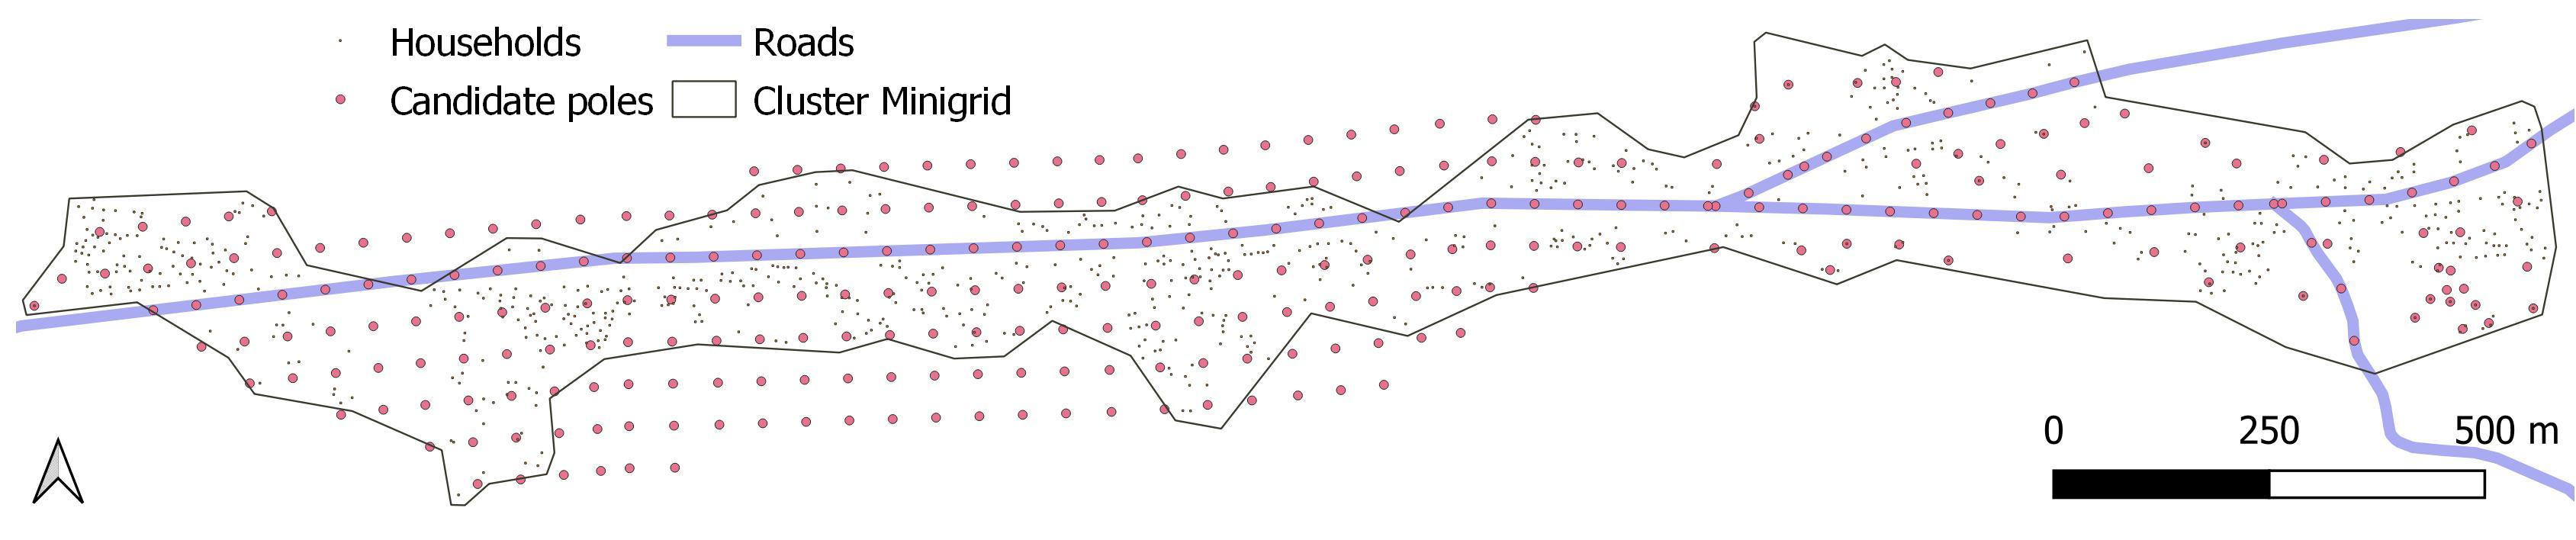

In [13]:
def poles_for_search(roads_clipped):
    """
    This function identifies candidate locations for poles to connect households 
    to the road network. It achieves this by:

    1. Identifying main roads.
    2. Creating a set of "backbone" poles along the centerlines of the main road 
     at a specified distance (50 meters here).
    3. Create perpendicular poles to the main road at 50 meters of distance and 
    total variable length.    The final length will depend to the relative distance to other roads
    to avoid overlapping.
    4. Create poles on other main roads and perpendicular poles to them. It includes the already existing
    candidate poles to avoid overlapping poles.
   
    
    This function returns three GeoDataFrames containing:
    - Backbone poles (`points_on_backbone_gdf`).
    - All candidate poles, including backbone and those from perpendicular lines 
    (`points_on_backbone_and_branches_gdf`).
    - Geometries of the created perpendicular lines (`branches_gdf`).

    Note: This function relies on several external functions that were already included 
    (e.g., `identifying_truck`, `poles_along_road`, `calculate_lengths_of_branches`, 
    `perpendicular_lines`, `calculate_points_on_line`).
    """
    roads_main_truck=identifying_truck(roads_clipped)
    roads_without_long_road= roads_main_truck.drop(index=0)
    
    perpendicular_lines_list = []
    branches=[]
    points_on_backbone_and_branches_gdf = gpd.GeoDataFrame(geometry=[], crs=local_crs)
    points_on_perpendicular_lines_gdf=gpd.GeoDataFrame(geometry=[], crs=local_crs)
    points_on_backbone_gdf=gpd.GeoDataFrame(geometry=[], crs=local_crs)
    starting_index=1
    idx_main_road=1
    distance_poles_main_trunk=50
    
    for index, road in roads_main_truck.iterrows():
        line = road['geometry']
         
        if line.length < 150:
            continue
        
        if index == 0:
            # Process the first road
            poles_main_truck = poles_along_road(line, distance_poles_main_trunk, index, idx_main_road)
            idx_main_road+=1
            poles_main_truck_longest_road = poles_main_truck
            points_on_backbone_gdf = pd.concat([points_on_backbone_gdf, poles_main_truck], ignore_index=True)
            branches.append(line)
            
            # Iterate over points_on_backbone_gdf (poles_main_truck)
            for j in range(len(poles_main_truck) - 1):  #
                current_row = poles_main_truck.iloc[j]
                
                # Check if the next index is within bounds
                if j + 1 < len(poles_main_truck):
                    next_row = poles_main_truck.iloc[j + 1]
                    current_geometry = current_row.geometry
                    next_geometry = next_row.geometry
    
                    distance_min = calculate_lengths_of_branches(index, current_geometry, roads_without_long_road)

                    
                    #print(distance_min)
                    if distance_min < 50:
                        continue
    
                    elif distance_min>50:
                        length_line=distance_min/2
                        #print(length_line)
                        perpendicular_line = perpendicular_lines(current_geometry, next_geometry, (length_line // 50) * 50)
                        points_on_perpendicular_lines= calculate_points_on_line(perpendicular_line, current_geometry, 50, 
                                                                                 int(length_line/50), starting_index, index)
                        branches.append(perpendicular_line)
                        starting_index+=1
                        idx_main_road+=1
                        #points_on_perpendicular_lines = calculate_points_on_line(line, midpoint, d, n, j, starting_index)
    
                        points_on_perpendicular_lines_gdf_compare = pd.concat([points_on_perpendicular_lines_gdf, 
                                                                               points_on_perpendicular_lines, 
                                                                               poles_main_truck_longest_road], 
                                                                              ignore_index=True, sort=False)
                        points_on_perpendicular_lines_gdf = pd.concat([points_on_perpendicular_lines_gdf, 
                                                                       points_on_perpendicular_lines], 
                                                                      ignore_index=True, sort=False)

                        #print(points_on_perpendicular_lines_gdf)
                        #points_on_perpendicular_lines_gdf.loc[points_on_perpendicular_lines_gdf.index, 'geometry_to_pole'] = current_geometry      
                    
        elif index != 0:
            #print(index)
            poles_main_truck = poles_along_road(line, distance_poles_main_trunk, index, idx_main_road)
            idx_main_road=+1
            
            points_on_backbone_gdf = pd.concat([points_on_backbone_gdf, poles_main_truck], ignore_index=True)
            branches.append(line)
            
            for j in range(len(poles_main_truck)-1):
                current_row = poles_main_truck.iloc[j]
                next_row = poles_main_truck.iloc[j + 1]
                current_geometry = current_row.geometry
                next_geometry = next_row.geometry
                
                #distance_to_point = min(points_on_perpendicular_lines_gdf.distance(current_geometry))

                   # Check if distances array is empty
                if len(points_on_perpendicular_lines_gdf) == 0:
                    distance_to_point = 300  # Set default distance to 300
                    
                else:
                    # Find the minimum distance
                    distance_to_point = min(points_on_perpendicular_lines_gdf.distance(current_geometry))
                                           
                if distance_to_point < 50:
                    continue
                
                elif distance_to_point > 50:
                    length_line=distance_to_point/2
                    #print(distance_to_point)
                    perpendicular_line = perpendicular_lines(next_geometry, current_geometry, (length_line // 50) * 50)
                    points_on_perpendicular_lines= calculate_points_on_line(perpendicular_line, current_geometry, 50, 
                                                                                 int(length_line/50), starting_index, index)
                    idx_main_road+=1
                    starting_index=starting_index+1
                    points_on_perpendicular_lines_gdf = pd.concat([points_on_perpendicular_lines_gdf, 
                                                                   points_on_perpendicular_lines], 
                                                                  ignore_index=True, sort=False)
                    branches.append(perpendicular_line)
    
                    #points_on_perpendicular_lines_gdf.loc[points_on_perpendicular_lines_gdf.index, 'geometry_to_pole'] = current_geometry
                    
    points_on_backbone_and_branches_gdf = pd.concat([points_on_backbone_gdf, points_on_perpendicular_lines_gdf], ignore_index=True, sort=False)
    branches_gdf = gpd.GeoDataFrame(geometry=branches, crs=local_crs)

    return points_on_backbone_gdf, points_on_backbone_and_branches_gdf, branches_gdf


### 2.4 Calculating drop lines

A service drop is understood as an electrical line running from a utility pole to a household (or other infrastructure). This part of the script will split the polygon into smaller areas using the previously introduced Voronoi function and connect households to the closest pole. Poles that are not used to connect households are discarded.

In [14]:
def calculate_service_lines(buildings, concatenated):
    """
    This function calculates service lines (electrical connections) between 
    buildings and the previously identified candidate poles.
    Args:
    buildings (GeoDataFrame): A GeoDataFrame containing building locations 
                               (geometry column). MultiPoint geometries will 
                               be represented by their centroid.
    concatenated (GeoDataFrame): A GeoDataFrame containing the candidate 
                                   poles identified for connection (e.g., output 
                                   from `poles_for_search`).
    Returns:
      tuple: A tuple containing two GeoDataFrames:
          - service_lines (GeoDataFrame): Contains the geometry of the 
                                         service lines (LineString) and 
                                         additional attributes like "Type" 
                                         and "Length".
          - remaining_poles (GeoDataFrame): Contains information about 
                                            the remaining poles that were 
                                            used to connect  
                                            buildings (including their IDs 
                                            and coordinates). """ 
    
    if buildings.empty or concatenated.empty:
        raise ValueError("Input GeoDataFrames cannot be empty")
    
    lines = []
    closest_points =[]
    list_id_1 = []
    list_id_2 = []
    list_id_3 = []
    list_id_4= []
    #list_id_5 = []
    list_id_6 = []
    for _, building in buildings.iterrows():
        building_point = building.geometry
        if isinstance(building_point, MultiPoint):
            # If the building geometry is MultiPoint, find the centroid
            building_point = building_point.centroid
        min_distance = float('inf')
        closest_point = None
        for _, point in concatenated.iterrows():
            distance = building_point.distance(point.geometry)
            if distance < min_distance:
                min_distance = distance
                closest_point = point.geometry
                id_1 = point.ID_Road
                id_2 = point.geometry_to_pole_x
                id_3 = point.ID_branch
                id_4 = point.geometry_to_pole_y
                #id_5 = point.index
                id_6 = point.ID_No
        line = LineString([building_point, closest_point])
        lines.append(line)
        closest_points.append(closest_point)
        list_id_1.append(id_1)
        list_id_2.append(id_2)
        list_id_3.append(id_3)
        list_id_4.append(id_4)
        #list_id_5.append(id_5)
        list_id_6.append(id_6)
        

    remaining_poles = gpd.GeoDataFrame({'ID_Road': list_id_1, 'ID_branch': list_id_3, 'x': list_id_2,
                                        'y': list_id_4,
                                        'ID_No': list_id_6, 'geometry': closest_points}, crs=local_crs)
    service_lines = gpd.GeoDataFrame(geometry=lines, crs=local_crs)
    service_lines['Type'] = 'Service line'
    service_lines['Length'] = service_lines['geometry'].length

    
    return service_lines, remaining_poles

In [15]:
def calculating_service_lines_with_voronoi(mg_geometry, voronoi, buildings_clipped, poles_for_local_search):
    """
    This function calculates service lines (electrical connections) between 
      buildings and the previously identified candidate poles, considering Voronoi 
      diagrams for improving computational times.
    
      Args:
          mg_geometry (GeoDataFrame): A GeoDataFrame representing the division of the cluster of the minigrid.
          voronoi (GeoDataFrame): A GeoDataFrame containing the Voronoi 
                                  diagram for cluster of the minigrid.
          buildings_clipped (GeoDataFrame): A GeoDataFrame containing building 
                                            locations clipped to the service 
                                            area. 
          poles_for_local_search (GeoDataFrame): A GeoDataFrame containing 
                                                 candidate poles for connection 
                                                 identified within the service 
                                                 area.
    
      Returns:
          tuple: A tuple containing two GeoDataFrames:
              - service_lines_households_2 (GeoDataFrame): Contains the geometry 
                                                        of the service lines 
                                                        (LineString) and additional 
                                                        attributes like "Type" and 
                                                        "Length" (potentially 
                                                        calculated later).
              - remaining_poles_2 (GeoDataFrame): Contains information about 
                                                   the remaining poles that were 
                                                   not used to connect any 
                                                   buildings (including their IDs 
                                                   and coordinates).  
    """

    
    list_buildings=[]
    list_poles = []
    remaining_polygons = gpd.overlay(voronoi, mg_geometry, how='symmetric_difference')
    all_polygons = remaining_polygons.explode(index_parts=False)
    all_polygons['area']=all_polygons.area
    filtered_small_areas = all_polygons[all_polygons['area'] >= 2500]
    completed_voronoi = pd.concat([voronoi, filtered_small_areas])
    voronoi_all = completed_voronoi.explode(index_parts=False)
    service_lines_households_2 = gpd.GeoDataFrame(geometry=[], crs=local_crs)
    remaining_poles_2 = gpd.GeoDataFrame(geometry=[], crs=local_crs)
    buildings_voronoi_division_no_poles = gpd.GeoDataFrame(geometry=[], crs=local_crs)
    
    for index, row in voronoi_all.iterrows():
        geometry_voronoi = row.geometry
        mg_voronoi_no_buffer = gpd.GeoDataFrame(geometry=[geometry_voronoi], crs=local_crs)
        mg_voronoi = gpd.GeoDataFrame(geometry=[mg_voronoi_no_buffer.unary_union.buffer(0.1)], crs=local_crs)
        buildings_voronoi_division = gpd.sjoin(buildings_clipped, mg_voronoi, how='inner', predicate='within')
        poles_voronoi_division = gpd.sjoin(poles_for_local_search, mg_voronoi, how='inner', predicate='within')
        
        if buildings_voronoi_division.empty:
            continue
            
        if poles_voronoi_division.empty:
            buildings_voronoi_division_no_poles = pd.concat([buildings_voronoi_division_no_poles, buildings_voronoi_division])
            continue
            
        service_lines_households_partial, remaining_poles_partial = calculate_service_lines(buildings_voronoi_division, poles_voronoi_division)
        service_lines_households_2 =pd.concat([service_lines_households_2,service_lines_households_partial])
        remaining_poles_2 = pd.concat([remaining_poles_2, remaining_poles_partial])
        len_buildings = len(buildings_voronoi_division)
        len_poles = len(poles_voronoi_division)
        list_buildings.append(len_buildings)
        list_poles.append(len_poles)
    
    if not buildings_voronoi_division_no_poles.empty:
        service_lines_households_partial, remaining_poles_partial = calculate_service_lines(buildings_voronoi_division_no_poles, poles_for_local_search)
        service_lines_households_2 =pd.concat([service_lines_households_2,service_lines_households_partial])
        remaining_poles_2 = pd.concat([remaining_poles_2, remaining_poles_partial])

    return service_lines_households_2, remaining_poles_2

### 2.5. Creating remaining atributes of the distribution grid.

The following functions focus on retrieving information to rebuild the trunk lines and branches, as well as the necessary poles to connect various utility poles where users will connect. The final LineString and Point layers will enable estimation of the final distribution quantities.

In [16]:
def retrieving_branches(remaining_poles):
    """
      This function processes a GeoDataFrame of remaining poles and extracts information about branches.
    
      It performs the following steps:
        1. Cleans and preprocesses the remaining poles DataFrame.
        2. Calculates branch geometry (linestrings) and associated attributes like length and angle.
        3. Groups branches by their starting point and filters out duplicates, keeping only the longest branch for each location.
        4. Creates separate GeoDataFrames for the final branches and poles located on those branches.
        5. Assigns types ('Branch' and 'Pole_with_users') to each GeoDataFrame for clarity.
    
      Args:
          remaining_poles (GeoDataFrame): A GeoDataFrame containing information about remaining poles.
    
      Returns:
          tuple: A tuple containing two GeoDataFrames:
              - branches_final: A GeoDataFrame containing information about the final set of branches (geometry, length).
              - Poles_on_branches: A GeoDataFrame containing information about poles located on the final branches.
    """

    def filter_longest_branch(group):
        # Initialize a list to store filtered branches
        filtered_branches = []
    
        # Iterate over unique angles in the group
        unique_angles = group['Angle'].unique()
        for angle in unique_angles:
            # Filter branches for the current angle and select the longest one
            max_length_branch = group[group['Angle'] == angle].nlargest(1, 'Length')
            # Append the longest branch to the list
            filtered_branches.append(max_length_branch)
    
        # Concatenate all filtered branches into a single DataFrame
        return pd.concat(filtered_branches, ignore_index=True)

    def calculate_angle(point1, point2):
        # Extract coordinates from points
        x1, y1 = point1.x, point1.y
        x2, y2 = point2.x, point2.y
        
        # Calculate the differences
        dx = x2 - x1
        dy = y2 - y1
        
        # Calculate the angle in radians
        angle_rad = math.atan2(dy, dx)
        return math.degrees(angle_rad)

    
    rp=remaining_poles.sort_values(by='geometry')
    rp_unique = rp.drop_duplicates(subset='geometry', keep='first')
    rp_sorted=rp_unique.sort_values(by='ID_branch')
    rp_clean=rp_sorted.dropna(subset=['ID_branch'])
    
    Line_branches=[]
    Angles = []
    Lengths = []
    Start_x=[]
    Start_y=[]
    for jindex, fila in rp_clean.iterrows():
        point_x = fila['x']
        point_y = fila['y']
        starting_point = Point(point_x, point_y)
        ending_point= fila['geometry']
        branch=LineString([starting_point, ending_point])
        angle = calculate_angle(starting_point, ending_point)
        length=branch.length
        Line_branches.append(branch)
        Angles.append(int(angle))
        Lengths.append(int(length))
        
        Start_x.append(starting_point.x)
        Start_y.append(starting_point.y)
        #print(starting_point, " ", ending_point)
    
    branches=gpd.GeoDataFrame({'geometry':Line_branches, 'Length':Lengths, 'Angle':Angles, 'Starting_point_x':Start_x, 'Starting_point_y':Start_y }, crs=local_crs)
    
    branches_grouped = branches.groupby(['Starting_point_x', 'Starting_point_y'])
    
    # Apply the custom function to each group and combine the results
    result = branches_grouped.apply(filter_longest_branch).reset_index(drop=True)
    
    # Recover CRS information from the original GeoDataFrame
    result.crs = branches.crs
    
    branches_final = result.drop(['Angle', 'Starting_point_x', 'Starting_point_y'], axis=1)
    
    branches_final['Type'] = 'Branch'

    Poles_on_branches = gpd.GeoDataFrame(geometry=rp_clean['geometry'].copy(), crs=local_crs)

    Poles_on_branches['Type'] = 'Pole_with_users'
    
    return branches_final, Poles_on_branches
    

In [17]:
def retrieving_atributes_trunck(branches, remaining_poles, points_on_backbone_gdf):
    """
    Retrieve trunk-related attributes and geometry based on input data.

    Parameters:
        branches (GeoDataFrame): DataFrame containing branch data.
        remaining_poles (DataFrame): DataFrame with remaining poles data.
        points_on_backbone_gdf (GeoDataFrame): DataFrame with points on the backbone.

    Returns:
        Tuple[GeoDataFrame, GeoDataFrame]: A tuple containing:
            - poles_main_trunk_final (GeoDataFrame): DataFrame of poles on the main trunk.
            - lines_main_trunk_final (GeoDataFrame): DataFrame of trunk lines.
    """
    
    dropped_poles = remaining_poles.drop_duplicates(subset="geometry")
    grouped= dropped_poles.groupby('ID_Road')['ID_No'].agg(['min', 'max'])
    grouped_poles_1 = grouped.reset_index()
    
    intersection = gpd.overlay(points_on_backbone_gdf, branches, how='intersection')
      
    grouped= intersection.groupby('ID_Road')['ID_No'].agg(['min', 'max'])
    grouped_poles=grouped.reset_index()

    merged = pd.merge(grouped_poles, grouped_poles_1, on='ID_Road', suffixes=('_intersection', '_remaining'))
    merged['min'] = merged[['min_intersection', 'min_remaining']].min(axis=1)
    merged['max'] = merged[['max_intersection', 'max_remaining']].max(axis=1)
    final_grouped_poles = merged[['ID_Road', 'min', 'max']]

    poles_for_main_trunck = []
    lines_for_main_trunck = []
    
    # Sort points_on_backbone_gdf DataFrame by 'ID_Road' and 'ID_No'
    points_on_backbone_gdf.sort_values(by=['ID_Road', 'ID_No'], inplace=True)
    
    # Iterate over rows in grouped_poles DataFrame
    for id, row in final_grouped_poles.iterrows():
        id_road = row['ID_Road']
        min_pole = row['min']
        max_pole = row['max']
    
        # Skip processing if min_pole is equal to max_pole
        if min_pole == max_pole:
            continue
    
        # Iterate over sorted points_on_backbone_gdf DataFrame
        for index_x, row_x in points_on_backbone_gdf.iterrows():
            if row_x['ID_Road'] == id_road and row_x['ID_No'] == min_pole and row_x['ID_No'] < max_pole:
                # Get current geometry
                current_geometry = row_x.geometry
    
                # Get next geometry (assuming next row based on sorted order)
                next_index = index_x + 1
                if next_index < len(points_on_backbone_gdf):
                    next_row = points_on_backbone_gdf.loc[next_index]
                    next_geometry = next_row.geometry
    
                    # Create LineString from current and next geometries
                    line = LineString([current_geometry, next_geometry])
                    lines_for_main_trunck.append(line)
                    poles_for_main_trunck.append(current_geometry)
                    
                    # Increment min_pole to move to the next pole (if needed)
                    min_pole += 1  # Assuming min_pole should be incremented for next iteration
    
    poles_main_trunck_partial = gpd.GeoDataFrame(geometry=poles_for_main_trunck, crs=local_crs)
    poles_main_trunck_partial['Type']='Pole on main trunck'
    lines_main_trunck_final = gpd.GeoDataFrame(geometry=lines_for_main_trunck, crs=local_crs)
    lines_main_trunck_final['Length']= lines_main_trunck_final['geometry'].length
    lines_main_trunck_final['Type']='Trunck'
    
    
    # Select only the desired columns
    selected_columns = ['ID_Road', 'ID_No']
    subset_gdf = dropped_poles[selected_columns]
    
    # Remove rows with infinite or empty values in ID_Road or ID_No
    subset_gdf = subset_gdf.replace([np.inf, -np.inf], np.nan)  # Replace infinite values with NaN
    subset_gdf = subset_gdf.dropna(subset=['ID_Road', 'ID_No'])  # Drop rows with NaN in ID_Road or ID_No
    
   
    new_gdf = gpd.GeoDataFrame(subset_gdf, geometry=dropped_poles.geometry)
    
    new_gdf.crs = dropped_poles.crs
    
    new_gdf['Type']='Pole with users'
    
    trunck_partial=pd.concat([new_gdf, poles_main_trunck_partial])
    
    trunck_sorted = trunck_partial.sort_values(by='geometry')
    
    trunck_unique = trunck_sorted.drop_duplicates(subset='geometry', keep='first')

    trunck_unique = trunck_unique.reset_index(drop=True)
    
    poles_main_trunck_final = trunck_unique.drop(['ID_Road', 'ID_No'], axis=1)

    return poles_main_trunck_final, lines_main_trunck_final

The necessary relative paths are defined for reading data and for outputting GeoPackage files to specific folders.

In [18]:
cntry = "Zambia"
cntryc = "zm"

# Define path and name of the file#

ROOT_DIR = os.path.abspath(os.curdir)
admin_path = ROOT_DIR + "\\" + 'Input_Data'

admin_name = "{}_admin.gpkg".format(cntryc)

# Define path and name of the file
mg_path = ROOT_DIR + "\\" + 'Input_Data' + '\\' + 'VIDA_Oct_18_2023'
mg_name = "VIDA_all_settlements_18102023.gpkg"

#Administrative_Layer
admin_map= ROOT_DIR + "\\" + 'Input_Data' + '\\' + "{}_admin.gpkg".format(cntryc)

#roads_map_layer
roads_gpkg= ROOT_DIR + "\\" + 'Input_Data' + "\\" + 'Roads' + "\\" + "{}_roads.gpkg".format(cntryc)
roads_name = "{}_roads.gpkg".format(cntryc)


# Path of result files
outpath= ROOT_DIR + "\\" + 'Output_Data'

In [20]:
#Adding road map to desing main truck line service
local_crs=32736 #Local CRS, this variable is important do not delete or change
road_gdf= gpd.read_file(roads_gpkg)
buildings_gdf = gpd.read_file(admin_path + '\\' + "Buildings_data" + '\\' + 'zm_buildings.gpkg' )
buildings_gdf=buildings_gdf[buildings_gdf['area_in_meters']>15] # Buildings with area in meters bigger than 15 meters are considered
zambia = gpd.read_file(mg_path + "\\" + 'Zambia_34_MG_sites.gpkg')

In [21]:
#Changing CRS to local crs.
zambia_to_crs=zambia.to_crs(epsg=local_crs)
roads_to_crs = road_gdf.to_crs(local_crs)
buildings_to_crs=buildings_gdf.to_crs(local_crs)

These two lines of code are not essential but prevent several identified mistakes from being printed. The code's performance remains unaffected. However, it could potentially create discrepancies in future updates.

In [22]:
warnings.filterwarnings("ignore", message="All-NaN slice encountered", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="`keep_geom_type=True` in overlay resulted in.*", category=UserWarning)

In [23]:
zambia_test = zambia_to_crs
total_grid_id=gpd.GeoDataFrame(geometry=[], crs=local_crs)
total_poles_id=gpd.GeoDataFrame(geometry=[], crs=local_crs)
total_grid=gpd.GeoDataFrame(geometry=[], crs=local_crs)
total_poles=gpd.GeoDataFrame(geometry=[], crs=local_crs)

list_id=[]
list_buildings=[]
list_grid_1=[]
list_poles=[]
list_time_1=[]
list_service_lines = []

for index, row in zambia_test.iterrows():
    id_mg = row['Site Unique ID (VIDA)_2'] 
    geometry_from_row = zambia_test.loc[zambia_test['Site Unique ID (VIDA)_2'] == id_mg].geometry
    mg_geometry= gpd.GeoDataFrame(geometry= [geometry_from_row.iloc[0]], crs=local_crs)
    buildings_clipped, roads_clipped= clip_geometries(mg_geometry, buildings_to_crs, roads_to_crs)
    No_buildings=len(buildings_clipped)
    
    #if id_mg != 20794:
     #  continue  # Skip processing if not the specific ID
    
    if buildings_clipped.empty or id_mg == 300 or id_mg == 13999:
        continue  # Skip processing due to problematic geometry or specific IDs

    if No_buildings < 10:
        continue  # Skip processing if fewer than 10 buildings

    if No_buildings > 1000:
        trunk_lines, voronoi = create_trunk_line(mg_geometry.geometry.iloc[0])
        roads_clipped = simplify_trunk_lines(trunk_lines)
        
    if roads_clipped.empty:
        # Retry simplification if roads_clipped is empty
        trunk_lines, voronoi = create_trunk_line(mg_geometry.geometry.iloc[0])
        roads_clipped = simplify_trunk_lines(trunk_lines)

    trunk_lines, voronoi = create_trunk_line(mg_geometry.geometry.iloc[0])
    points_on_backbone_gdf, points_on_backbone_and_branches_gdf, branches_gdf = poles_for_search(roads_clipped)
    poles_for_clusters = buildings_clustering(buildings_clipped, local_crs)
    
    if poles_for_clusters is None or len(poles_for_clusters) == 0:
        
        poles_for_local_search = clip(mg_geometry, points_on_backbone_and_branches_gdf)
    
    else:        
        #poles_for_clusters = calculate_centroids(buildings_clusters)
        buffer_distance = 40  
        buffered_polygon = points_on_backbone_and_branches_gdf.unary_union.buffer(buffer_distance)
        clipped_centroids = gpd.overlay(poles_for_clusters, gpd.GeoDataFrame(geometry=[buffered_polygon], crs=local_crs), how='symmetric_difference',
                                        keep_geom_type=True)
        #clipped_poles, clipped_poles = clip_geometries(buildings_clipped.unary_union.buffer(20), 
                                                      #points_on_backbone_and_branches_gdf, points_on_backbone_and_branches_gdf)
        clipped_poles, clipped_poles = clip_geometries(mg_geometry, points_on_backbone_and_branches_gdf, points_on_backbone_and_branches_gdf)

        
        poles_from_centroids, lines_from_centroids, poles_missing_gdf = find_closest_points_with_interpolation(clipped_centroids, clipped_poles, 50)
        poles_for_local_search= pd.concat([clipped_centroids, clipped_poles, poles_from_centroids], sort=False, ignore_index=True)
    
    start_t = time.time()
    
    service_lines_households, remaining_poles = calculating_service_lines_with_voronoi(mg_geometry, voronoi, buildings_clipped, poles_for_local_search)
    s_70 = service_lines_households[service_lines_households["Length"]>70]
    percentage_sl=100-(len(s_70)/len(service_lines_households))*100
    list_service_lines.append(percentage_sl)
    remaining_poles = pd.concat([remaining_poles, poles_missing_gdf], ignore_index=True, sort=False)
    branches, poles_branches= retrieving_branches(remaining_poles)
    
    poles_main_trunck, lines_main_trunck = retrieving_atributes_trunck(branches, remaining_poles, points_on_backbone_gdf)
    total_grid= pd.concat([lines_main_trunck, service_lines_households, branches, lines_from_centroids])
    total_grid['ID_VIDA']=id_mg
    clipped_centroids = clipped_centroids.drop(columns=['latitude', 'longitude', 'cluster'])
    total_poles = pd.concat([poles_main_trunck, poles_branches, poles_from_centroids, clipped_centroids])
    total_poles['ID_VIDA'] = id_mg
    total_len_design = total_grid['Length'].sum()/1000
    total_no_poles = len(total_poles)
    end_t=time.time()
    time_t=(end_t-start_t)/60

    #print(id_mg, "--", total_len_design, "--", time_t,  "--", percentage_sl)

    list_id.append(id_mg)
    list_buildings.append(No_buildings)
    list_grid_1.append(total_len_design)
    list_poles.append(total_no_poles)
    list_time_1.append(time_t)

    create_gpkg = "yes"

    if create_gpkg == "yes": 
        total_grid_id=pd.concat([total_grid_id, total_grid], ignore_index=True, sort=False)
        total_poles_id=pd.concat([total_poles_id, total_poles], ignore_index=True, sort=False)
        total_grid_id.to_file(outpath + '\\' + "Minigrid_design_grids.gpkg", driver="GPKG")
        total_poles_id.to_file(outpath + '\\' + "Minigrid_design_poles.gpkg", driver="GPKG")
        print("Minigrid design grids succesfully created in folder for ID:", id_mg)
    else:
        print("Minigrid design grids succesfully created for ID:", id_mg)
        summary_mst = pd.DataFrame({
        "ID_VIDA": list_id,
        "No. Buildings": list_buildings,
        "Total length design (km)": list_grid_1,
        "No. Poles": list_poles,
        "Time design": list_time_1,
        "% SL < 70m": list_service_lines
        })          
        


Minigrid design grids succesfully created in folder for ID: 13446
Minigrid design grids succesfully created in folder for ID: 9051
Minigrid design grids succesfully created in folder for ID: 2932
Minigrid design grids succesfully created in folder for ID: 19774
Minigrid design grids succesfully created in folder for ID: 15870
Minigrid design grids succesfully created in folder for ID: 4804
Minigrid design grids succesfully created in folder for ID: 22218
Minigrid design grids succesfully created in folder for ID: 8275
Minigrid design grids succesfully created in folder for ID: 9106
Minigrid design grids succesfully created in folder for ID: 23146
Minigrid design grids succesfully created in folder for ID: 7695
Minigrid design grids succesfully created in folder for ID: 2885
Minigrid design grids succesfully created in folder for ID: 2460
Minigrid design grids succesfully created in folder for ID: 3425
Minigrid design grids succesfully created in folder for ID: 20794
Minigrid design gri

In [24]:
grid_2460 = total_grid_id[total_grid_id["ID_VIDA"]==2460]
poles_2460 = total_poles_id[total_poles_id["ID_VIDA"]==2460]

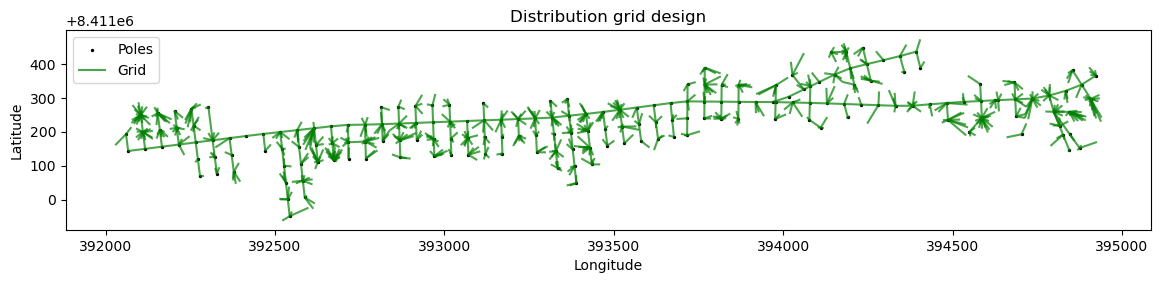

In [25]:
# Plotting the first GeoPackage layer
plt.figure(figsize=(14, 10))  # Optional: set the figure size
poles_2460.plot(ax=plt.gca(), color='black', label='Poles', markersize=2)

# Plotting the second GeoPackage layer
grid_2460.plot(ax=plt.gca(), color='green', label='Grid', alpha=0.7)

# Customize plot (add title, legend, etc.)
plt.title('Distribution grid design')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Display the plot
plt.show()